# **Infer cis co-accessibility network**

In [1]:
pip show circe-py

Name: circe-py
Version: 0.3.8
Summary: Circe: Package for building co-accessibility networks from ATAC-seq data.
Home-page: https://github.com/cantinilab/circe
Author: Remi-Trimbour
Author-email: remi.trimbour@pasteur.fr
License: GPL-3.0-only
Location: /home/rtrimbou/miniconda3/envs/circe_local/lib/python3.10/site-packages
Editable project location: /home/rtrimbou/ATACNet/circe
Requires: anndata, attrs, Cython, dask, distributed, joblib, numpy, pandas, rich, scanpy, scikit-learn
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import circe as ci
import scanpy as sc
import scipy as sp

## 0. Import (or create) data

#### Create fake AnnData

This data doesn't contain strong correlation between fake regions, the score will then be low. 

It will still allow us to demonstrate how to use Circe. :)

In [3]:
atac = sc.datasets.blobs(n_centers=8, n_variables=2_000, n_observations=300, random_state=1)
atac.X = np.random.poisson(lam=0.2, size=atac.X.shape)
cell_names = [f"cell_{i}" for i in range(1, atac.shape[0]+1)]
# number of chr_start_end region names
region_names = [[f"chr{i}_{str(j)}_{str(j+399)}" 
                 for j in range(1, 10000*400+1, 10000)] 
                for i in range(1, 6)]
regions_names = [item for sublist in region_names for item in sublist]
# select a random number of regions per cell, and make it 0
for i in range(atac.shape[0]):
    num_regions = np.random.randint(500, 1000)
    region_indices = np.random.choice(len(regions_names), num_regions, replace=False)
    atac.X[i, region_indices] = 0

atac.var_names = regions_names
atac.obs_names = cell_names

## 1. Preprocess the data

#### 1.1. Filter the data

In [4]:
sc.pp.filter_genes(atac, min_cells=30)
sc.pp.filter_cells(atac, min_genes=20)

_Make sure to all your features (peaks) are expressed in at least 1 of the cells:_

In [5]:
sc.pp.filter_genes(atac, min_counts=1)

### 1.2. Add region position in AnnData.obs

Let's first run `add_region_infos` that will <font color=#F98128>**add coordinate annotations**</font> `chr`, `start`, `end` as columns in `atac.var` slot

In [6]:
ci.add_region_infos(atac, inplace=True)
atac.var.head(3)

,n_cells,n_counts,chromosome,start,end
chr1_20001_20400,31,32,chr1,20001,20400
chr1_30001_30400,38,45,chr1,30001,30400
chr1_40001_40400,32,32,chr1,40001,40400


### 2. Compute pseudocells

<font color=#F98128>**Compute metacells**</font> is an interesting step to reduce sparsity in our data, since scATAC-seq data have usually a lot of dropouts.

In [7]:
metacells = ci.metacells.compute_metacells(atac)

Output()

You can also use your own dimensionality reduction space, that would be stored in the atac.obsm slot

In [8]:
atac.obsm["dim_reduction_name"] = atac.X

In [9]:
ci.metacells.compute_metacells(atac, dim_reduction="dim_reduction_name")

Using adata.obsm['dim_reduction_name'] to identify neighboring cells


Output()

AnnData object with n_obs × n_vars = 299 × 1644
    var: 'n_cells', 'n_counts', 'chromosome', 'start', 'end'

### 3. Calculate co-accessibility

#### 3.A. Human datasets

We can finally <font color=#F98128>**compute all the cis co-accessibility scores**</font> ! <br>
The default way is to <font color='#50B848'>**indicate your organism**</font> if among the one known by Circe.<br>
The atac network is stored automatically as a sparse matrix in `atac.varp["atac_network"]`

In [10]:
ci.compute_atac_network(
    metacells,
    njobs=3, verbose=0,
    window_size=100000,
    unit_distance=1000,
    distance_constraint=50000,
    s=0.75,)

Output()

Output()

Calculating co-accessibility scores...
Concatenating results from all chromosomes...


In [11]:
circe_network = ci.extract_atac_links(
    metacells)

#### 3.B. Other organisms

##### If your organism is **not** <font color=#50B848>"human"</font>, <font color=#50B848>"mouse"</font> or <font color=#50B848>"drosophila"</font>, human default values will be used for:
`s`, `window_size` and `distance_constraint`.
Distance constraint is usually half of the window size.

If you know their values,
you can also specify yourself the following parameters that are organism-specific.

#### 3.C. Use of sparse matrix

1. Circe can also work with `sparse covariance matrix`.<br>

In [12]:
atac.X = sp.sparse.csr_matrix(atac.X)

2. Connections can also be stored externally from your `AnnData` object using `sliding_graphical_lasso`.

In [13]:
final_score = ci.sliding_graphical_lasso(
    metacells,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=500,
    verbose=0
)

# You can then add it in a second time
metacells.varp['atac_network'] = final_score

/home/rtrimbou/ATACNet/circe/circe/circe.py:958: UserWarning: 
                No organism, nor value passed for the parameters: ['window_size', 'distance_constraint', 's'],
                using default values.
                The default values are defined from human and mouse data,
                you might want to change them if you are working with
                another organisms.

                Default values used:
                {'window_size': 500000, 'distance_constraint': 250000, 's': 0.75}

                You can check how to define them in https://cole-trapnell-lab.github.io/cicero-release/docs_m3/#important-considerations-for-non-human-data.
                
  warnings.warn(


Output()

Output()

Calculating co-accessibility scores...


/home/rtrimbou/ATACNet/circe/circe/circe.py:1114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_var.loc[:, map_indices] = np.arange(len(chr_var), dtype=np.int64)
/home/rtrimbou/ATACNet/circe/circe/circe.py:1114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_var.loc[:, map_indices] = np.arange(len(chr_var), dtype=np.int64)
/home/rtrimbou/ATACNet/circe/circe/circe.py:1114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

Concatenating results from all chromosomes...


### 4. Extract connections

#### 4.A.Get the whole genome cis-coaccessible network

You can <font color='#F98128'>**extract connections**</font> from the atac.varp slot (sparse matrix), as a `DataFrame object` with `extract_atac_links`.

In [14]:
circe_network = ci.extract_atac_links(metacells) #atac)
circe_network.head(3)

,Peak1,Peak2,score
0,chr1_2770001_2770400,chr1_3210001_3210400,0.325869
1,chr1_1010001_1010400,chr1_1320001_1320400,0.304926
2,chr4_2580001_2580400,chr4_2750001_2750400,0.300668


#### 4.B. Subset the AnnData object to a given window

If you're interested in a specific genomic region only, you can also <font color='#F98128'>**subset your anndata object**</font> on this specific window

In [18]:
subset_atac = ci.subset_region(metacells, "chr1", 10_000, 200_000).copy()

In [19]:
circe_network_subset = ci.extract_atac_links(subset_atac)
circe_network_subset.head(3)

,Peak1,Peak2,score
0,chr1_110001_110400,chr1_130001_130400,0.049829
1,chr1_130001_130400,chr1_180001_180400,0.048972
2,chr1_80001_80400,chr1_150001_150400,0.033743


### 5. Plot co-accessibility scores in a window

You can pass either your `anndata` object or your freshly extracted `dataframe` into `plot_connections` to <font color=#F98128>**visualize all Circe scores**</font>.<br>
<font color='#4584b6'>**Blue edges**</font> correspond to positive co-accessibility scores, while <font color='#ffde57'>**yellow ones**</font> are for negative scores

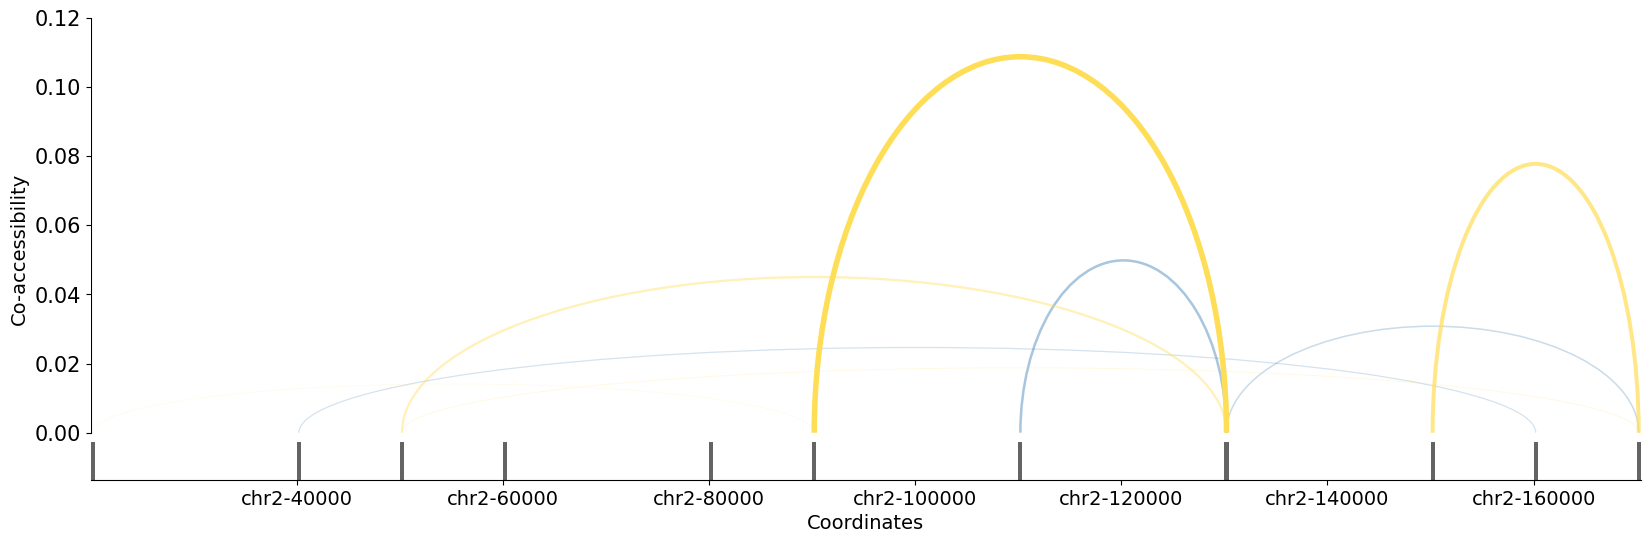

In [20]:
ci.plot_connections(
    circe_network,
    chromosome="chr2",
    start=10_000,
    end=200_000,
    sep=("_","_"),
    abs_threshold=0.01
)

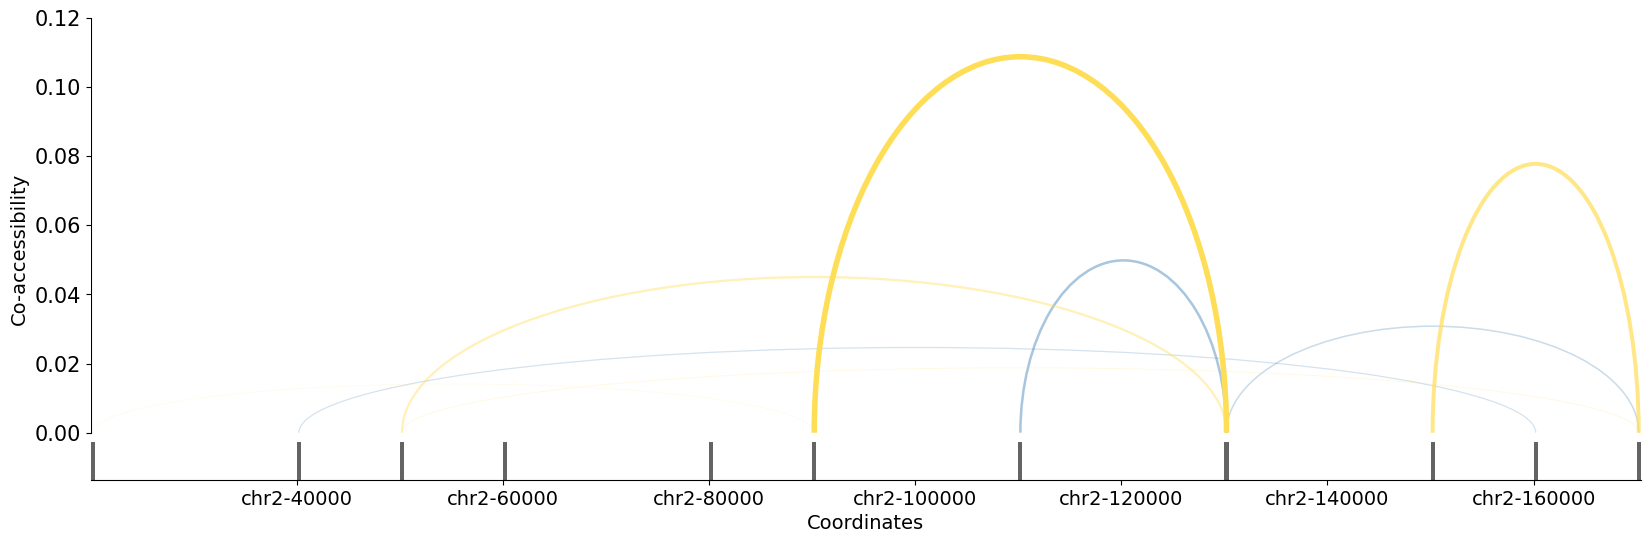

In [21]:
ci.plot_connections(
    metacells,
    chromosome="chr2",
    start=10_000,
    end=200_000,
    sep=("_","_"),
    abs_threshold=0.01
)

### 6. Find cis-coaccessible connected modules

In addition to pairwise co-accessibility scores, Circe can also be used to <font color=#F98128>**define cis co-accessibility modules**</font> (called CCANs by Cicero), which are modules of sites that are highly co-accessible with one another. We use the Louvain community detection algorithm (Blondel et al., 2008) to find clusters of sites that tended to be co-accessible.<br>
- The function `find_ccans` takes as input a `connection data frame` or the `anndata object` once again, and outputs a data frame with CCAN assignments for each input peak.<br>
- You can also use `add_ccans` to directly add CCAN assignments to your anndata object as `anndata.var['CCAN']`. The regions that aren't assigned to a CCAN will contain `None`.

In [22]:
ccans = ci.find_ccans(circe_network, seed=0)
ccans.head(3)

Coaccessibility cutoff used: 0.02
Number of CCANs generated: 70


,Peak,CCAN
0,chr1_2910001_2910400,0
1,chr1_3360001_3360400,0
2,chr1_3400001_3400400,0


In [23]:
metacells = ci.add_ccans(metacells)
metacells.var.head(3)

Coaccessibility cutoff used: 0.03


,n_cells,n_counts,chromosome,start,end,CCAN
chr1_20001_20400,31,32,chr1,20001,20400,None
chr1_30001_30400,38,45,chr1,30001,30400,None
chr1_40001_40400,32,32,chr1,40001,40400,None


In [24]:
metacells.var['CCAN'].value_counts().head(3)

CCAN
35    52
37    42
8     36
Name: count, dtype: int64

With default `coaccess_cutoff_override=None`, the function will determine and report an appropriate co-accessibility score cutoff value for CCAN generation based on the number of overall CCANs at varying cutoffs. You can also set `coaccess_cutoff_override` to be a numeric between 0 and 1, to override the cutoff-finding part of the function. This option is useful if you feel that the cutoff found automatically was too strict or loose, or for speed if you are rerunning the code and know what the cutoff will be, since the cutoff finding procedure can be slow. 

In [25]:
ccans = ci.find_ccans(circe_network, seed=0, coaccess_cutoff_override=1e-7)

Coaccessibility cutoff used: 1e-07
Number of CCANs generated: 37


#### 6.B. Plot only a CCAN module

If you're interested in a specific CCAN module, you can use `circe.draw.plot_ccan` function, precising its CCAN name. Only the connections between <font color=#F98128>**regions belonging to this CCAN module will be plotted**</font>.

This CCAN module is on the chromosome: chr3


/home/rtrimbou/ATACNet/circe/circe/draw.py:244: UserWarning: varp parameter is ignored for DataFrame input.
  warnings.warn(


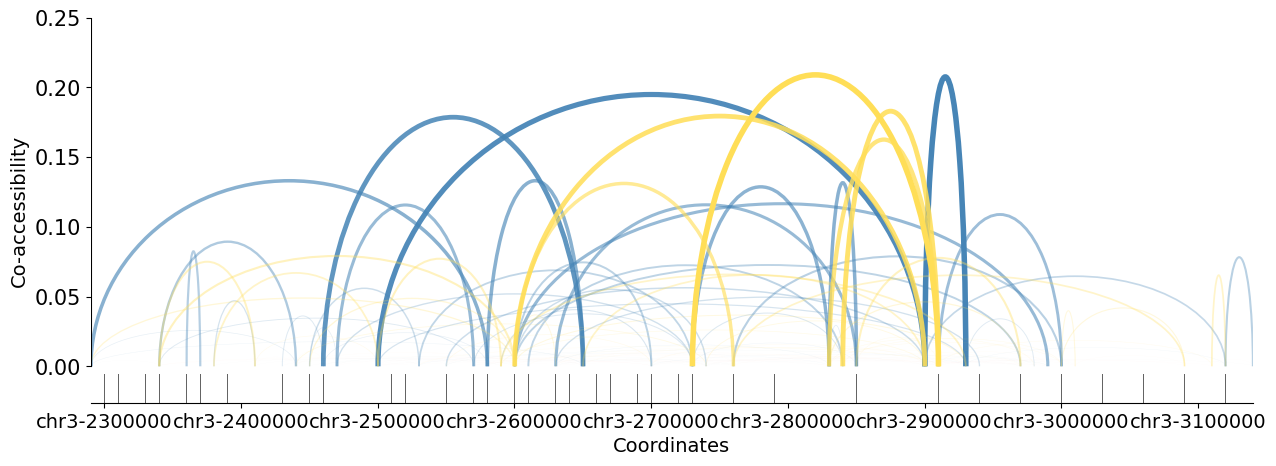

In [26]:
ci.draw.plot_ccan(
    metacells,
    ccan_module=metacells.var['CCAN'].value_counts().index[1],
    sep=('_', '_'),
    abs_threshold=0,
    figsize=(15,5),
    only_positive=False)

### 7.Coordinates overlap between co-accessible regions and gene bodies

To better understand the role of specific regions and modules, you can additionally plot <font color=#F98128>**gene bodies**</font> falling into your window of interest.
<br> You need first to load gene coordinates as a dataframe, or to download them through `circe.downloads.download_genes`. This functions will require to install the `pybiomart` package Then you can use `ci.draw.plot_connections_genes`, using gene infos and either your AnnData object or the dataframe of Circe's results to compare these locations. 

In [27]:
pip install pybiomart

Note: you may need to restart the kernel to use updated packages.


In [28]:
import circe.downloads
genes_df = ci.downloads.download_genes()

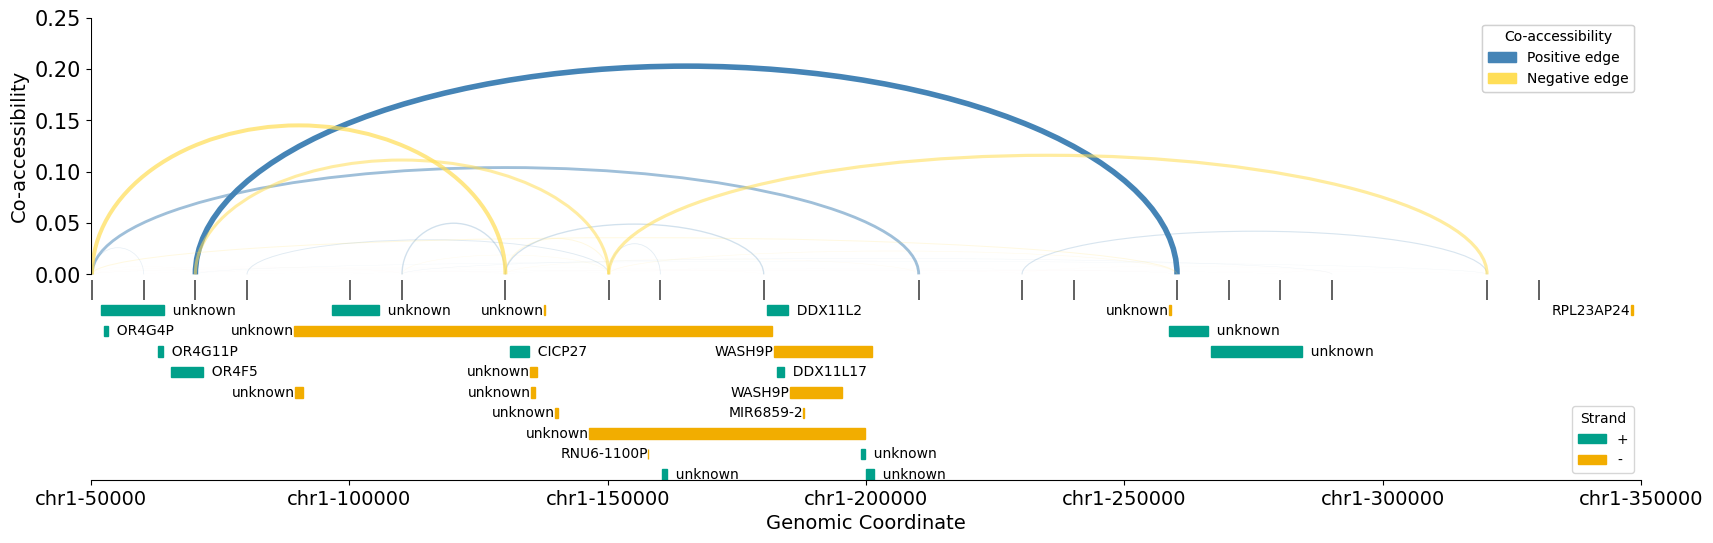

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize = (20, 6))
ci.draw.plot_connections_genes(
    connections=metacells,
    genes=genes_df,
    chromosome="chr1",
    start=50_000,
    end=350_000,
    gene_spacing=30_000,
    y_lim_top=-0.02,
    abs_threshold=0.0,
    track_spacing=0.01,
    track_width=0.01,
    legend=True,
    ax=ax
)

### 7. Work in progress! Happy to get feedbacks :)

If you feel any function could be useful for you on others, don't hesitate to write me at `remi.trimbour@pasteur.fr` or to submit an issue on `github.com/cantinilab/Circe`.